# Préparation du dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
# data
from google.colab import drive
drive.mount('/content/drive')

# timing managment
from tqdm import tqdm
from time import time

Mounted at /content/drive


In [4]:
path_data = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/'
path_image = path_data+'Images/'

data_source = pd.read_csv(path_data + 'flipkart_com-ecommerce_sample_1050.csv')

## Préparation des catégories

In [5]:
# We build category list with only top of the category tree
X = np.array(data_source['product_category_tree'])

# only keep the first category in each X elt
X_cat = [] # initialized category list
for i in range(len(X)):

  s = X[i]
  a, b = s.find('"') + 1, s.find(' >> ')
  cat = s[a : b]

  X_cat.append(cat)

In [6]:
from sklearn import preprocessing

# select image names and descriptions which are the only relevant features for preprocess and classification
data = data_source[['image', 'description']].copy()

# add path
data['image_path'] = [path_image+data['image'][i] for i in range(data.shape[0])]
data = data.drop(['description', 'image'], axis = 1)

# add category
data['label_name'] = X_cat

le = preprocessing.LabelEncoder()
le.fit(data["label_name"])
data["label"] = le.transform(data["label_name"])

In [7]:
d = data.groupby('label_name')['label'].mean()
d_lab = d.values.astype(int)
d_cat = np.array(d.index)

d_lab = d_lab.reshape(d_lab.shape[0], 1)
d_cat = d_cat.reshape(d_cat.shape[0], 1)

label_tab = np.concatenate([d_lab, d_cat], axis=1)

In [8]:
label_true_dict = {lab : cat for lab, cat in label_tab}

In [9]:
data['label_name'].value_counts()

label_name
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

In [10]:
data

image_path       label_name  \
0     /content/drive/MyDrive/FORMATION DATASCIENTIST...  Home Furnishing   
1     /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
2     /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
3     /content/drive/MyDrive/FORMATION DATASCIENTIST...  Home Furnishing   
4     /content/drive/MyDrive/FORMATION DATASCIENTIST...  Home Furnishing   
...                                                 ...              ...   
1045  /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
1046  /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
1047  /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
1048  /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   
1049  /content/drive/MyDrive/FORMATION DATASCIENTIST...        Baby Care   

      label  
0         4  
1         0  
2         0  
3         4  
4         4  
...     ...  
1045      0  
1046      0  
1047      0  
1048      0  
1049      0  

[1050 rows x 3 columns]

In [11]:
list_labels = data['label_name'].unique()

In [12]:
list_labels.shape

(7,)

Home Furnishing


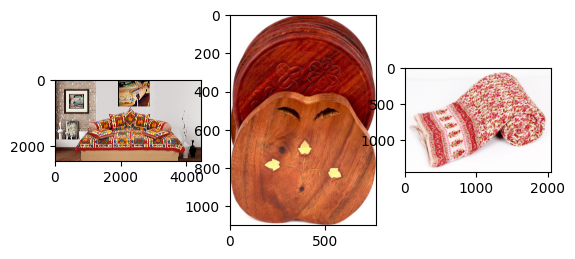

Baby Care


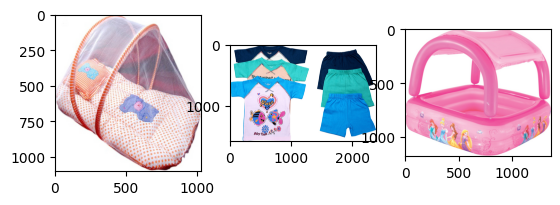

Watches


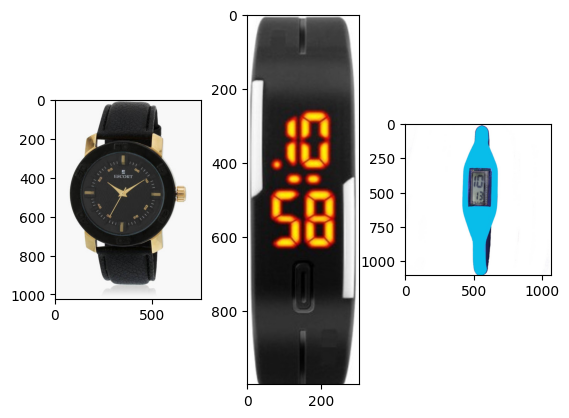

Home Decor & Festive Needs


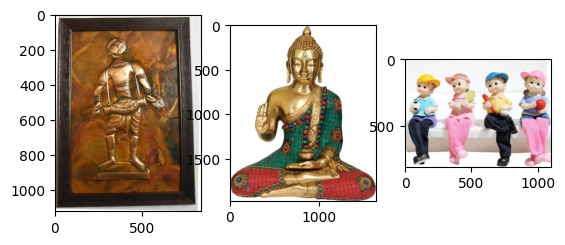

Kitchen & Dining


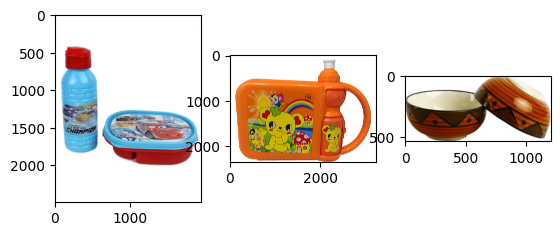

Beauty and Personal Care


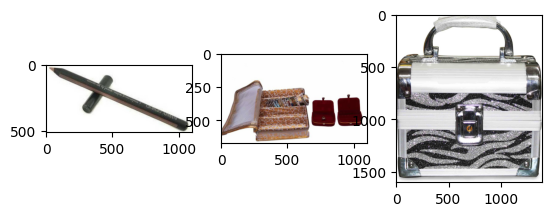

Computers


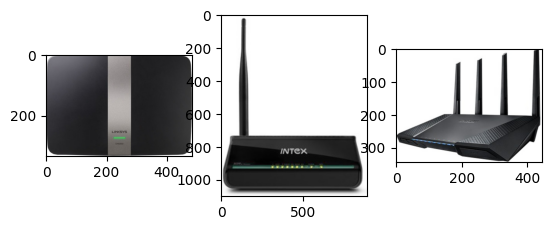

In [13]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["label_name"][i]==name]
    return list_image_name

for name in list_labels :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i+10]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité

## Création du modèle pré-entraîné

In [ ]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

553467096/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

## Création des features des images

In [ ]:
images_features = []
i=0
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :            14.75 secondes


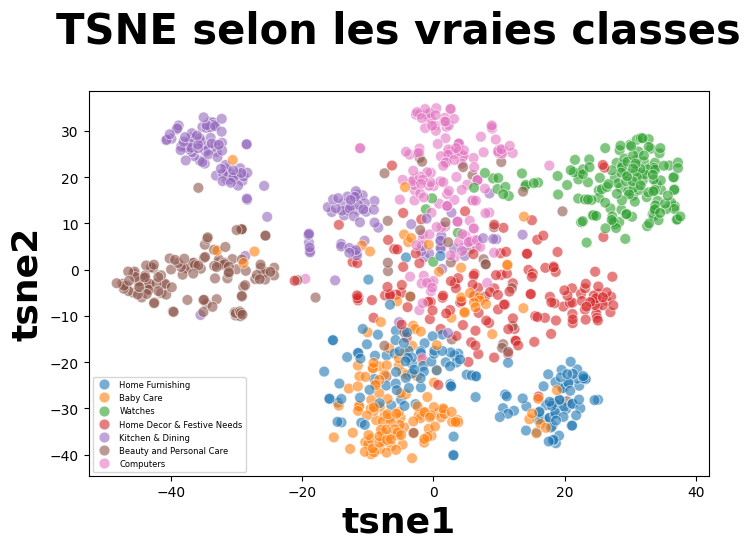

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["label_name"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=60, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 6})

plt.show()


* L'analyse graphique montre visuellement qu'il est réalisable de séparer automatiquement les images selon leurs vraies classes


### Création de clusters à partir du T-SNE et affichage des images selon clusters
* Attention : ici, il ne s'agit pas de faire une classification non supervisée, mais simplement, par une mesure de l'ARI, de conforter l'analyse graphique précédente qui démontre la faisabilité de réaliser ultérieurement une classification supervisée. Cette mesure de l'ARI nécessite de créer des clusters théoriques via KMeans
* Il s'agit donc de réaliser une mesure de ce que nous voyons graphiquement, donc à partir des données en sortie du t-sne
* Pour réaliser une classification non supervisée, il aurait fallu repartir des données avant t-sne
* Dans la démarche en 2 étapes, il n'est pas utile de réaliser une classification non supervisée, une classification supervisée est bien plus performante. Même le calcul de l'ARI n'est pas indispensable, nous pourrions passer directement du graphique t-sne précédent à l'étape 2 de classification supervisée
* Il n'est donc pas utile de passer du temps à optimiser l'ARI, un ordre de grandeur suffit pour conforter le 1er graphique t-sne. D'ailleurs la meilleure solution de feature engineering ne génère pas toujours le meilleur ARI. L'analyse graphique t-sne est bien plus riche d'enseignement


In [ ]:
from sklearn import cluster, metrics

In [ ]:
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

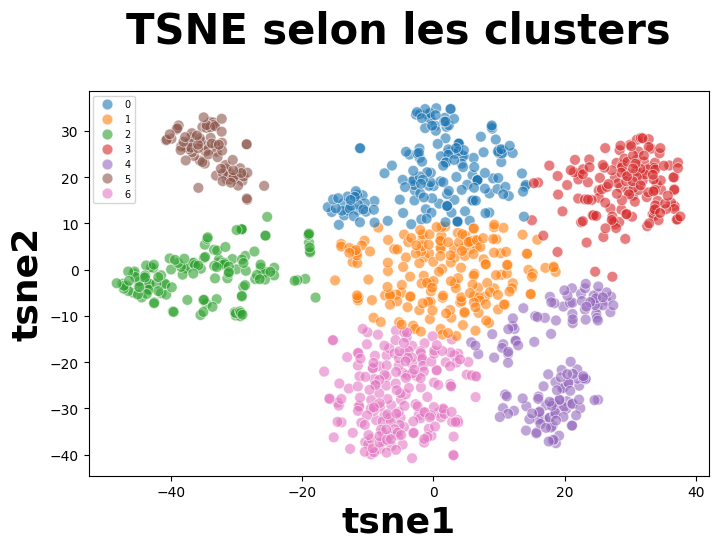

ARI :  0.45209807534416524


In [ ]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=60, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 7})

plt.show()

labels = data["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

* Analyse : le modèle pré-entraîné confond "cloud" avec de la neige ...

### Analyse par classes

In [ ]:
df_tsne.loc[df_tsne['class'] == 'Home Furnishing', ["class",	"cluster"]].cluster.value_counts()

6    79
4    66
1     5
Name: cluster, dtype: int64

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  2  26   3   0   9   1 109]
 [  9  12 117   1   5   1   5]
 [113  34   1   1   0   0   1]
 [  5  78   1   8  55   0   3]
 [  0   5   0   0  66   0  79]
 [ 32  30  10   0   0  78   0]
 [ 13   2   0 135   0   0   0]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

In [ ]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 3 1 6 4 5 0]
[[109   3   2  26   9   1   0]
 [  5 117   9  12   5   1   1]
 [  1   1 113  34   0   0   1]
 [  3   1   5  78  55   0   8]
 [ 79   0   0   5  66   0   0]
 [  0  10  32  30   0  78   0]
 [  0   0  13   2   0   0 135]]

              precision    recall  f1-score   support

           0       0.55      0.73      0.63       150
           1       0.89      0.78      0.83       150
           2       0.65      0.75      0.70       150
           3       0.42      0.52      0.46       150
           4       0.49      0.44      0.46       150
           5       0.97      0.52      0.68       150
           6       0.93      0.90      0.92       150

    accuracy                           0.66      1050
   macro avg       0.70      0.66      0.67      1050
weighted avg       0.70      0.66      0.67      1050



In [ ]:
label_true_dict

{0: 'Baby Care',
 1: 'Beauty and Personal Care',
 2: 'Computers',
 3: 'Home Decor & Festive Needs',
 4: 'Home Furnishing',
 5: 'Kitchen & Dining',
 6: 'Watches'}

<Axes: >

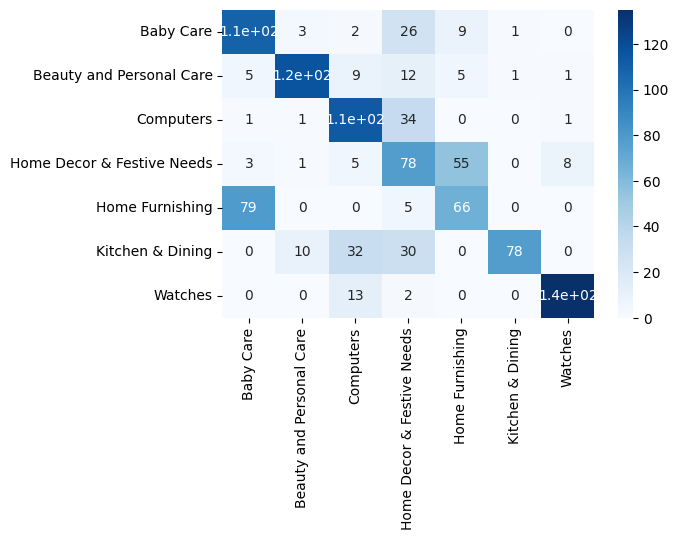

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label_true_dict[i] for i in label_true_dict.keys()],
                  columns = [label_true_dict[i] for i in label_true_dict.keys()])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

In [ ]:
# index des baby care classés en home funishing
list_bad_home = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Home Furnishing') and (cls_labels_transform[i]==0)]
len(list_bad_home)

79

In [ ]:
# affichage des n premiers "baby" considérée comme "home"
def conf_im_plot(n, list_id):
  k=1
  b = 10
  a = n // 10
  plt.figure(figsize=(12, 5))
  for i in list_id[:n]:

      plt.subplot(a, b, k)
      #if k % b == 0:
        #k = 1
        #a += 1
      #plt.subplot(1, n, k)
      k += 1
      filename = data["image_path"][i]
      image = imread(filename)
      plt.imshow(image)
  plt.show()

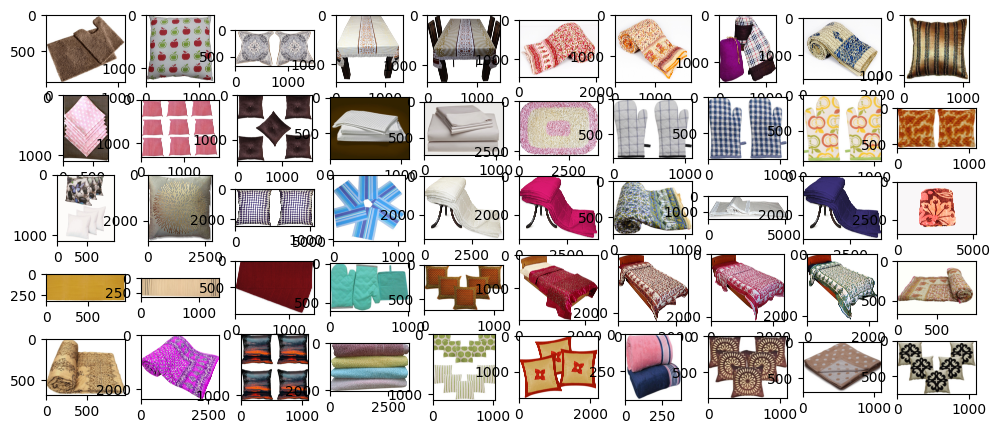

In [ ]:
conf_im_plot(n=50, list_id=list_bad_home)

 - On retrouve à priori beaucoup de cousins, serviettes et draps de "home" mal classés dans "baby".

In [ ]:
# index des "kitch" classés en "home funishing"
list_bad_decor = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Home Decor & Festive Needs') and (cls_labels_transform[i]==4)]
len(list_bad_decor)

55

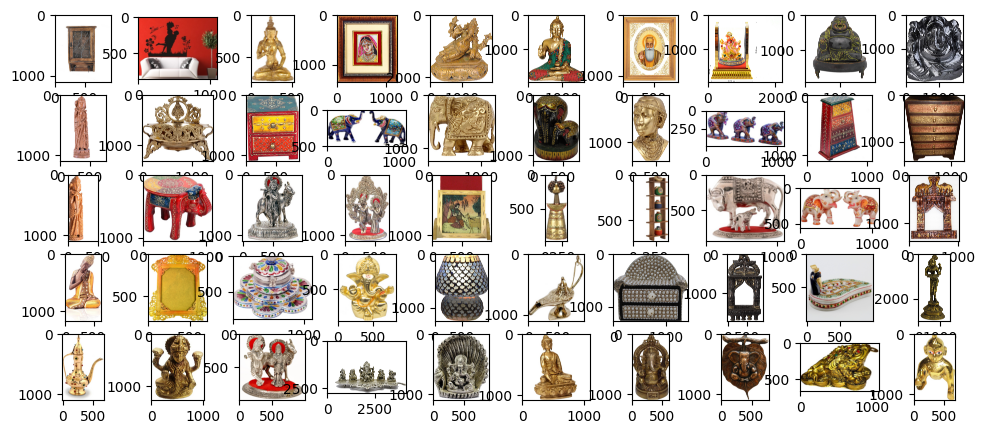

In [ ]:
conf_im_plot(n=50, list_id=list_bad_decor)

 - On retrouve à priori beaucoup de lampes et status de "decor" mal classés dans "home".

In [ ]:
# index des "Kitchen & Dining" classés en "Computers"
list_bad_computer = [i for i in range(len(data["image_path"])) \
                if (data.iloc[i]['label_name']=='Kitchen & Dining') and (cls_labels_transform[i]==2)]
len(list_bad_computer)

32

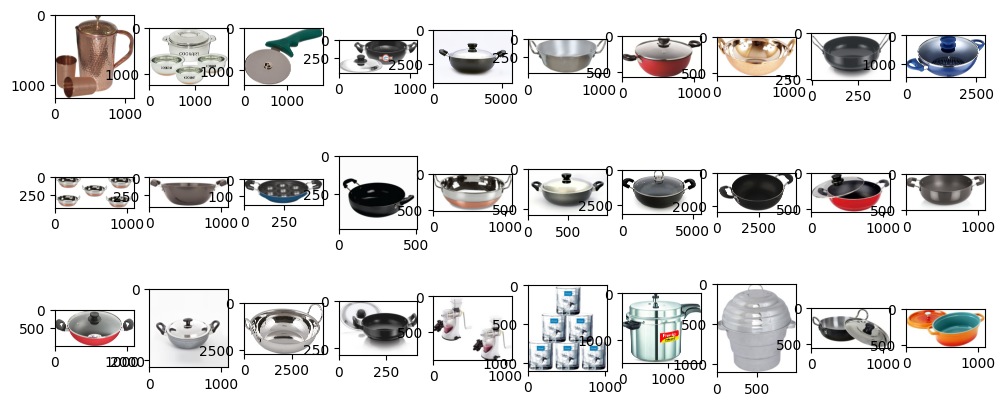

In [ ]:
conf_im_plot(n=30, list_id=list_bad_computer)

 - Une trentaine de casseroles se retrouvent proche des élément de "computer" dans l'espace. Cette fausse similarité est due à leur couleur grise caractéristique des éléments de "computer".

# Etape 2 : classification supervisée
4 approches sont présentées :
* Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [ ]:
def create_model_fct() :
    # Récupération modèle pré-entraîné
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Layer non entraînables = on garde les poids du modèle pré-entraîné
    for layer in model0.layers:
        layer.trainable = False

    # Récupérer la sortie de ce réseau
    x = model0.output
    # Compléter le modèle
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    # Définir le nouveau modèle
    model = Model(inputs=model0.input, outputs=predictions)
    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    print(model.summary())

    return model


## Approche préparation initiale des images

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in tqdm(range(data.shape[0])):
        img = (load_img(
            data.image_path[image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(data)
print(images_np.shape)

 64%|██████▍   | 677/1050 [05:18<03:54,  1.59it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 1050/1050 [10:27<00:00,  1.67it/s]

(1050, 224, 224, 3)


In [ ]:
X = images_np
y = to_categorical(data['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(672, 224, 224, 3)
(168, 224, 224, 3)
(210, 224, 224, 3)
(672, 7)
(168, 7)
(210, 7)


In [ ]:
path_data

'/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/'

In [ ]:
# export des tableaux pour éviter de refaire les calculs
np.savez(path_data + "donnees_couleur.npz", arr1=X_train, arr2=X_val, arr3=X_test, arr4=y_train, arr5=y_val, arr6=y_test)

In [ ]:
# Charger les données enregistrées dans le fichier "donnees.npz"
donnees_couleur = np.load(path_data + "donnees_couleur.npz")

# Extraire les tableaux individuels
X_train = donnees_couleur['arr1']
X_val = donnees_couleur['arr2']
X_test = donnees_couleur['arr3']
y_train = donnees_couleur['arr4']
y_val = donnees_couleur['arr5']
y_test = donnees_couleur['arr6']

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(672, 224, 224, 3)
(168, 224, 224, 3)
(210, 224, 224, 3)
(672, 7)
(168, 7)
(210, 7)


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = path_data + "model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [1]:
49*512

25088

In [ ]:
from keras.callbacks import CSVLogger

# Définir le chemin vers le fichier CSV où vous souhaitez enregistrer l'historique
csv_logger = CSVLogger(path_data + 'training_history.csv', append=True)

In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=[callbacks_list, csv_logger], validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
11/11 [==============================] - ETA: 0s - loss: 4.0987 - accuracy: 0.5119 
Epoch 1: val_loss improved from inf to 1.40263, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model1_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11/11 [==============================] - 593s 55s/step - loss: 4.0987 - accuracy: 0.5119 - val_loss: 1.4026 - val_accuracy: 0.7083
Epoch 2/50
11/11 [==============================] - ETA: 0s - loss: 1.5033 - accuracy: 0.7068 
Epoch 2: val_loss improved from 1.40263 to 1.12810, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model1_best_weights.h5
11/11 [==============================] - 631s 59s/step - loss: 1.5033 - accuracy: 0.7068 - val_loss: 1.1281 - val_accuracy: 0.7619
Epoch 3/50
11/11 [==============================] - ETA: 0s - loss: 1.1078 - accuracy: 0.7560 
Epoch 3: val_loss improved from 1.12810 to 1.10834, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model1_best_weights.h5
11/11 [==============================] - 557s 52s/step - loss: 1.1078 - accuracy: 0.7560 - val_loss: 1.1083 - val_accuracy: 0.7560
Epoch 4/50
11/11 [==============================] - ETA: 0s -

In [ ]:
path_data

'/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/'

charger le modèle et continuer l'entraînement

In [ ]:
# Sauvegarder le modèle
model1.save(path_data + 'mon_modele.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Charger le modèle à partir du fichier
from tensorflow.keras.models import load_model
model1 = load_model(path_data + 'mon_modele.h5')

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7798
Test Accuracy       :  0.7905


In [ ]:
# Accéder à l'historique de l'entraînement
history1 = model1.history

In [ ]:
pip install plot-keras-history

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.5/322.5 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.38-py3-none-any.whl size=9456 sha256=d8b3d161bd37cda72516463956248ecc01e61d32bb93ed4909a6399dd8c22244
  Stored in directory: /root/.cache/pip/wheels/2f/31/6c/bbc9703b7baa8bd3802a8aedd9e2f9e66941b0cf0d456ab4cc
  Created wheel for sanitize_ml_labels: filename=sanitize_ml_labels-1.0.51-py3-none-any.whl size=321866 sha256=cf72c41c83259e9cf7c6d70561013b0e9d0c2a1893480eab9aa606e82fc58238
  Stored in directory: /root/.cache/pip/wheels/30/9f/f5/37d037c39ac8b305590d5956f7021c6ca94b63c68be24f6841
  Created wheel for support_developer: filename=support_developer-1.0.5-py3-none-any.whl size=5630 sha256=cfbedefe13a4cae81f0be58ea22fbb57d7695f9f639b6fb535b7f81541e6debe
  Stored in directo

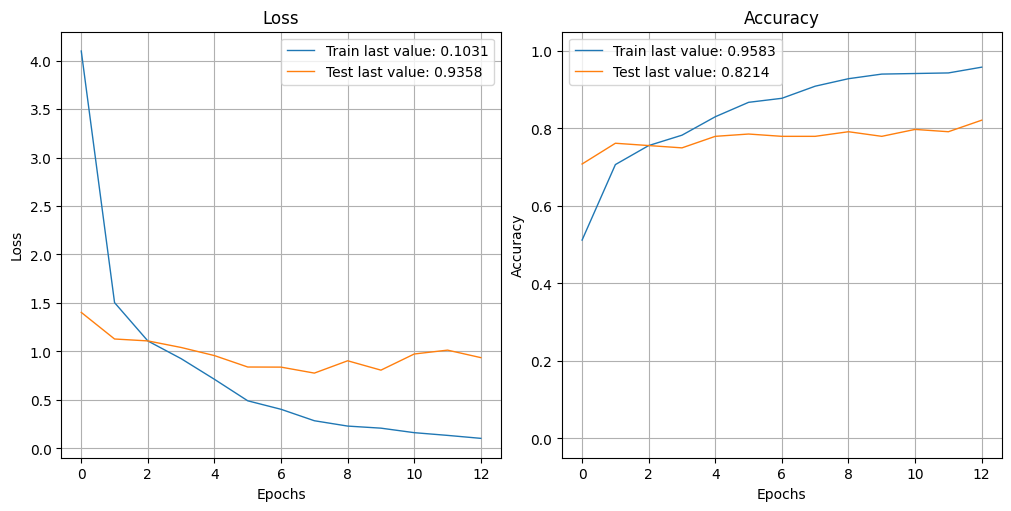

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path=path_data + "standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

6/6 [==============================] - 104s 16s/step
[3 1 1 1 0 0 0 2 3 0 1 4 2 3 3 0 3 0 4 1 6 3 0 1 4 2 5 1 0 4 5 0 5 3 2 6 2
 6 4 1 3 2 4 2 2 2 1 2 2 6 0 5 3 1 2 0 3 2 4 6 2 2 0 6 5 3 3 5 2 5 4 0 4 3
 0 0 5 1 1 3 5 0 5 3 0 6 1 5 6 4 6 5 6 6 2 5 1 6 6 2 3 3 4 5 2 3 2 4 3 0 2
 2 1 6 5 4 6 0 2 6 4 5 1 3 2 2 6 0 2 3 5 4 1 4 1 5 2 6 4 6 4 3 1 4 4 5 1 4
 3 4 4 1 6 1 5 4 3 6 0 3 1 3 3 6 6 2 5 1]

[3 1 1 1 5 4 4 2 3 0 1 0 2 0 3 0 3 0 4 1 6 3 0 1 4 2 5 3 3 1 5 0 5 3 2 6 2
 6 4 4 4 2 4 2 2 2 1 2 2 6 3 5 3 3 2 0 2 2 0 6 2 3 0 6 5 3 3 5 2 5 4 0 4 3
 0 0 5 1 1 3 5 0 5 3 0 6 3 5 6 4 6 2 2 6 2 2 1 6 6 2 3 3 0 5 2 3 2 0 3 0 2
 2 1 6 5 4 6 0 2 6 4 5 1 3 2 2 6 0 2 3 5 4 1 4 6 5 6 6 4 6 4 3 1 4 0 5 2 4
 6 0 3 3 6 1 5 4 3 6 0 3 1 3 3 6 6 2 5 2]


In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[16  0  0  2  2  1  0]
 [ 0 16  2  4  1  0  1]
 [ 0  0 26  1  0  0  1]
 [ 1  0  1 23  1  0  1]
 [ 6  1  0  1 16  0  0]
 [ 0  0  2  0  0 19  0]
 [ 0  0  1  0  0  0 22]]


In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [0 1 2 3 4 5 6]
[[16  0  0  2  2  1  0]
 [ 0 16  2  4  1  0  1]
 [ 0  0 26  1  0  0  1]
 [ 1  0  1 23  1  0  1]
 [ 6  1  0  1 16  0  0]
 [ 0  0  2  0  0 19  0]
 [ 0  0  1  0  0  0 22]]

              precision    recall  f1-score   support

           0       0.70      0.76      0.73        21
           1       0.94      0.67      0.78        24
           2       0.81      0.93      0.87        28
           3       0.74      0.85      0.79        27
           4       0.80      0.67      0.73        24
           5       0.95      0.90      0.93        21
           6       0.88      0.96      0.92        23

    accuracy                           0.82       168
   macro avg       0.83      0.82      0.82       168
weighted avg       0.83      0.82      0.82       168



<Axes: >

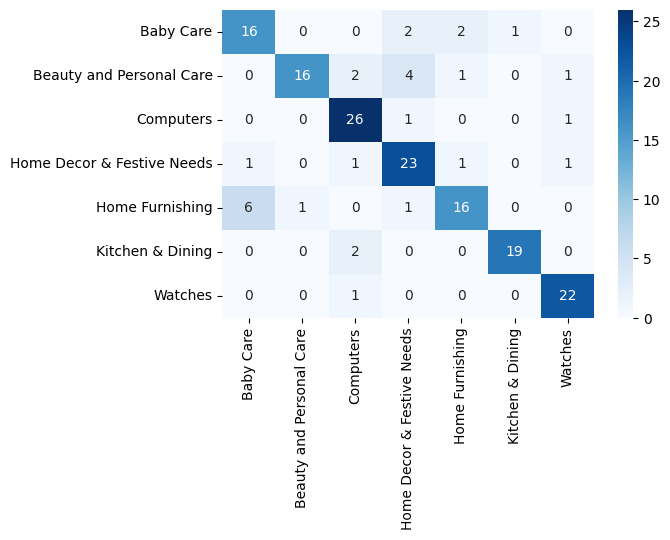

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label_true_dict[i] for i in label_true_dict.keys()],
                  columns = [label_true_dict[i] for i in label_true_dict.keys()])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

* Les images "Home furnishing" semble mieux classés.

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [15]:
# création d'un set de test à partir du dataframe initial
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test
d_train, d_test, dy_train, dy_test = train_test_split(data.image_path, data.label_name, test_size=0.2, stratify=data.label)

# création d'un validation set
skf = StratifiedKFold(n_splits=7)

# accumulation des indices des set de train et de test
for train_indices, val_indices in skf.split(d_train, dy_train):
    train = train_indices
    val = val_indices


In [16]:
# vérification
data_train = data[["image_path", "label_name"]].iloc[train, :]
data_val = data[["image_path", "label_name"]].iloc[val, :]
data_test = pd.concat([d_test, dy_test], axis=1)

print('train size : ', data_train.shape)
print('val size : ', data_val.shape)
print('test size : ', data_test.shape)

train size :  (720, 2)
val size :  (120, 2)
test size :  (210, 2)


In [ ]:
data_training = pd.concat([d_train, dy_train], axis=1)
data_training.to_csv(path_data + "data_train/data_training.csv")
data_test.to_csv(path_data + "data_train/data_testing.csv")

In [18]:
data_test.label_name.value_counts()

label_name
Home Decor & Festive Needs    30
Kitchen & Dining              30
Beauty and Personal Care      30
Home Furnishing               30
Watches                       30
Baby Care                     30
Computers                     30
Name: count, dtype: int64

In [19]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='label_name',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [20]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data_train, datagen_train, data_type='training')
val_flow = data_flow_fct(data_val, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(data_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 540 validated image filenames belonging to 7 classes.
Found 30 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


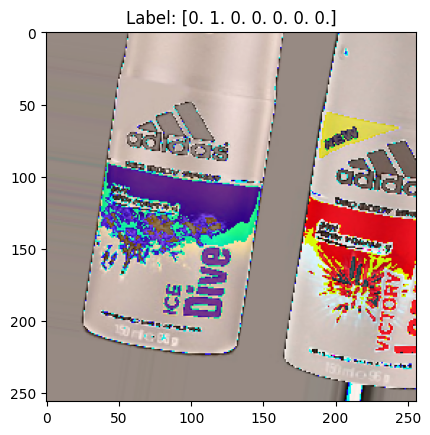

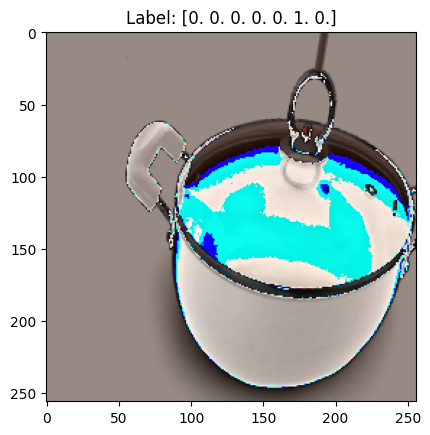

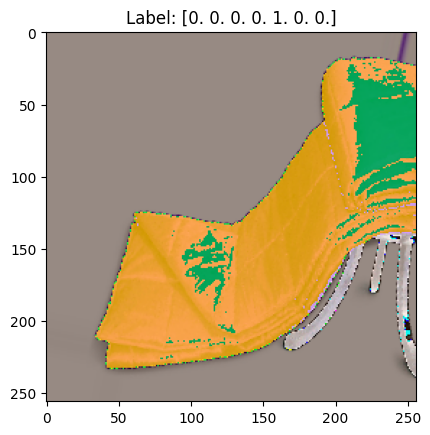

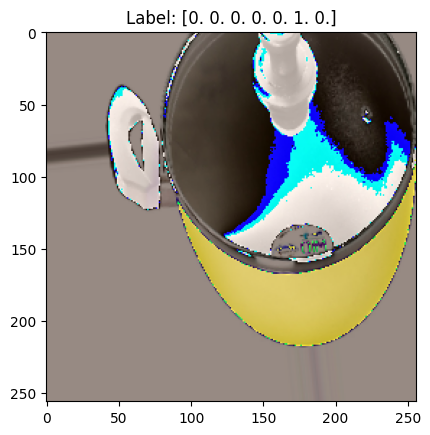

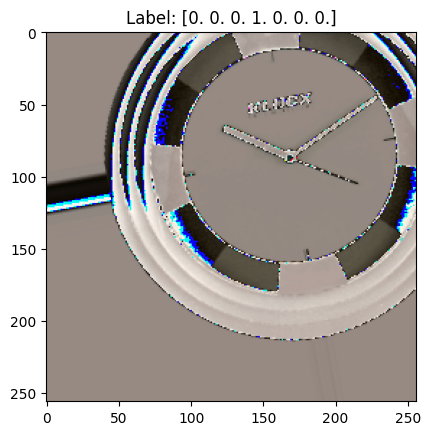

In [23]:
# Récupérer le prochain lot d'images augmentées
images, labels = next(train_flow)

# Afficher les premières images du lot
num_images_to_show = 5
for i in range(num_images_to_show):
    plt.imshow(images[i].astype('uint8'))  # Assurez-vous que les valeurs sont dans le bon intervalle pour l'affichage
    plt.title('Label: {}'.format(labels[i]))
    plt.show()


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = path_data + "model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


58889256/58889256 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
from keras.callbacks import CSVLogger

# Définir le chemin vers le fichier CSV où vous souhaitez enregistrer l'historique
csv_logger = CSVLogger(path_data + 'training_history2.csv', append=True)

In [ ]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=[callbacks_list, csv_logger], verbose=1)


In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = path_data + "model2_best_weights.h5"

In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8667
Test Accuracy       :  0.8762


In [ ]:
history2 = pd.read_csv(path_data + 'training_history2.csv')

In [ ]:
history2[history2.val_accuracy == history2.val_accuracy.max()]

epoch  accuracy      loss  val_accuracy  val_loss
13      9  0.911111  0.247449      0.866667  0.326271

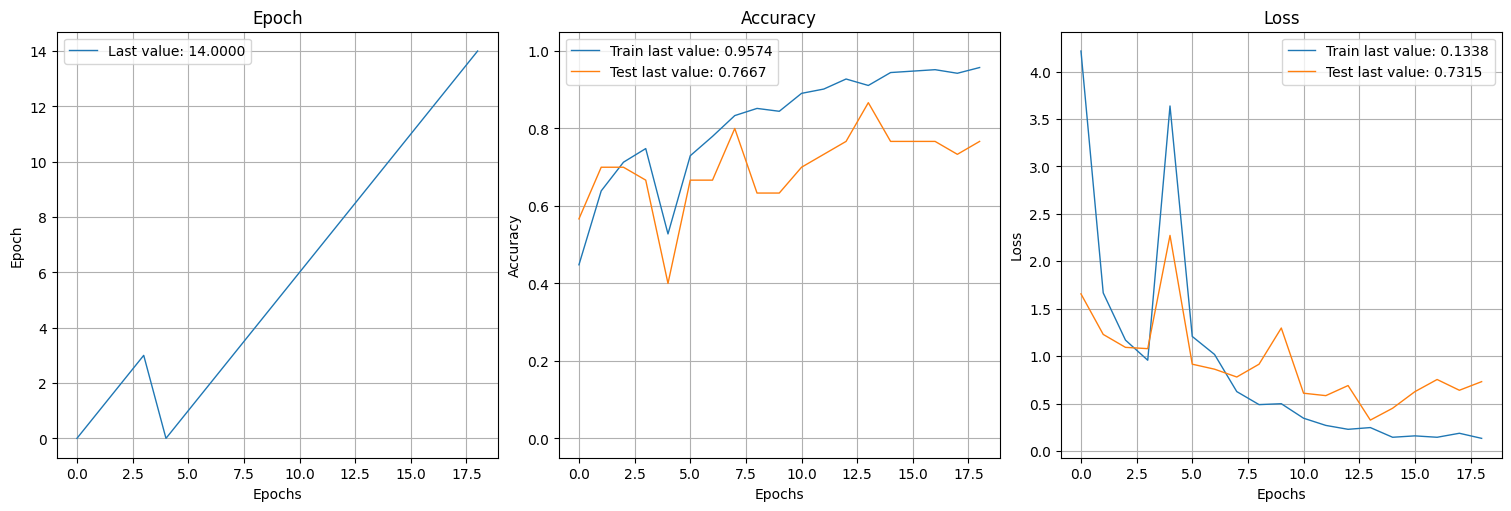

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path=path_data + "standard2.png")
plt.close()

## Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset


In [ ]:
print(data_training.shape)
print(data_test.shape)

(840, 2)
(210, 2)


In [ ]:
# création de dossiers d'image pour que la méthode image_dataset_from_directory puisse les parcourir et crer les mini-lots
import shutil

def create_image_directory(path, set_type, data):

  path_list = data.image_path.tolist()
  label_list = data.label_name.tolist()

  for i in tqdm(range(data.shape[0])):
    # Chemin source du fichier à déplacer
    source = path_list[i]
    image_name = source[source.rfind('/')+1:]

    # Chemin de destination du fichier
    destination = path + '/' + set_type + '/' + label_list[i] + '/' + image_name

    # Vérifier si le répertoire de destination existe
    if not os.path.exists(os.path.dirname(destination)):
        # Créer le répertoire de destination s'il n'existe pas
        os.makedirs(os.path.dirname(destination))

    # Créer une copie du fichier vers le nouveau répertoire
    shutil.copy(source, destination)

In [ ]:
path = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/Images/'
set_type = 'train'
data = data_training

# création des dossier train
create_image_directory(path, set_type, data)

100%|██████████| 840/840 [05:37<00:00,  2.49it/s]


In [ ]:
set_type = 'test'
data = data_test

# création des dossier test
create_image_directory(path, set_type, data)

100%|██████████| 210/210 [01:24<00:00,  2.48it/s]


In [ ]:
path = '/content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/Images/'
path_train = path + 'train/'
path_test = path + 'test/'

In [ ]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 840 files belonging to 7 classes.
Using 630 files for training.
Found 840 files belonging to 7 classes.
Using 210 files for validation.
Found 210 files belonging to 7 classes.


In [ ]:
dataset_train

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 7), dtype=tf.float32, name=None))>

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = path_data + "model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
from keras.callbacks import CSVLogger

# Définir le chemin vers le fichier CSV où vous souhaitez enregistrer l'historique
csv_logger = CSVLogger(path_data + 'training_history3.csv', append=True)

In [ ]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=[callbacks_list, csv_logger], verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 7.3878 - accuracy: 0.4349 
Epoch 1: val_loss improved from inf to 2.10387, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model3_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 560s 28s/step - loss: 7.3878 - accuracy: 0.4349 - val_loss: 2.1039 - val_accuracy: 0.7238
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.9473 - accuracy: 0.6381 
Epoch 2: val_loss improved from 2.10387 to 1.72972, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model3_best_weights.h5
20/20 [==============================] - 535s 27s/step - loss: 2.9473 - accuracy: 0.6381 - val_loss: 1.7297 - val_accuracy: 0.7238
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.5752 - accuracy: 0.7349 
Epoch 3: val_loss improved from 1.72972 to 1.49468, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model3_best_weights.h5
20/20 [==============================] - 595s 30s/step - loss: 1.5752 - accuracy: 0.7349 - val_loss: 1.4947 - val_accuracy: 0.7667
Epoch 4/50
20/20 [==============================] - ETA: 0s -

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 388s 19s/step - loss: 0.0069 - accuracy: 1.0000
Training Accuracy   : 1.0000

7/7 [==============================] - 128s 18s/step - loss: 1.4832 - accuracy: 0.7857
Validation Accuracy :  0.7857


In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8000
Test Accuracy       :  0.8095


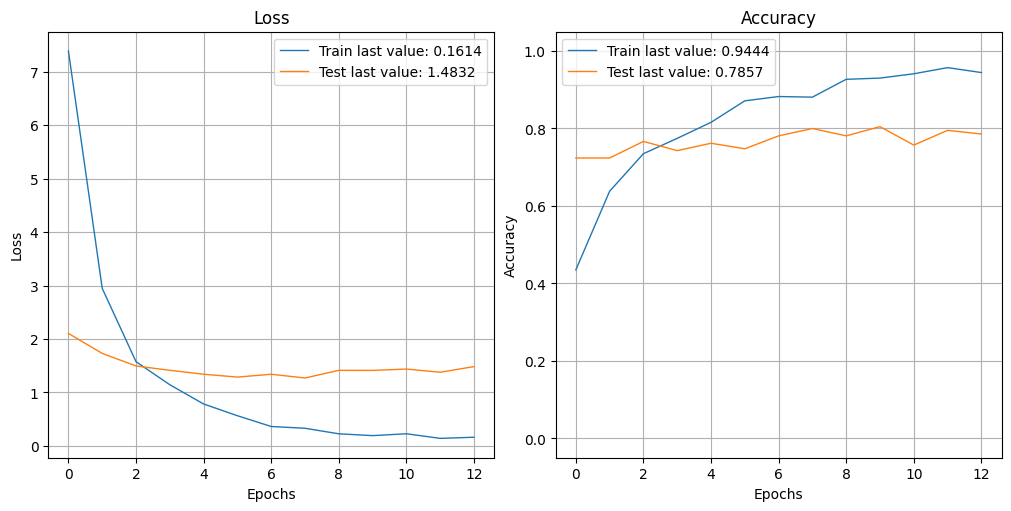

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path=path_data + "standard2.png")
plt.close()

## Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None, batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
dataset_train = dataset_fct(path, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

Found 400 files belonging to 4 classes.
Using 300 files for training.
Found 400 files belonging to 4 classes.
Using 100 files for validation.
Found 100 files belonging to 4 classes.


In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = path_data + "model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
from keras.callbacks import CSVLogger

# Définir le chemin vers le fichier CSV où vous souhaitez enregistrer l'historique
csv_logger = CSVLogger(path_data + 'training_history4.csv', append=True)

In [ ]:

model4.load_weights(model4_save_path)

In [ ]:
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=[callbacks_list, csv_logger], verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 0.5995 - accuracy: 0.8095 
Epoch 1: val_loss improved from inf to 0.77741, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model4_best_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 608s 27s/step - loss: 0.5995 - accuracy: 0.8095 - val_loss: 0.7774 - val_accuracy: 0.7476
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.8206 
Epoch 2: val_loss improved from 0.77741 to 0.77168, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model4_best_weights.h5
20/20 [==============================] - 485s 24s/step - loss: 0.5512 - accuracy: 0.8206 - val_loss: 0.7717 - val_accuracy: 0.7429
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 0.5649 - accuracy: 0.8159 
Epoch 3: val_loss improved from 0.77168 to 0.76856, saving model to /content/drive/MyDrive/FORMATION DATASCIENTIST OC - Lucas GAMBA/Projet 6/data/Flipkart/model4_best_weights.h5
20/20 [==============================] - 476s 24s/step - loss: 0.5649 - accuracy: 0.8159 - val_loss: 0.7686 - val_accuracy: 0.7429
Epoch 4/50
20/20 [==============================] - ETA: 0s -

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 347s 17s/step - loss: 0.3167 - accuracy: 0.9063
Training Accuracy   : 0.9063

7/7 [==============================] - 116s 16s/step - loss: 0.7754 - accuracy: 0.7429
Validation Accuracy :  0.7429


In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.7524
Test Accuracy       :  0.8048


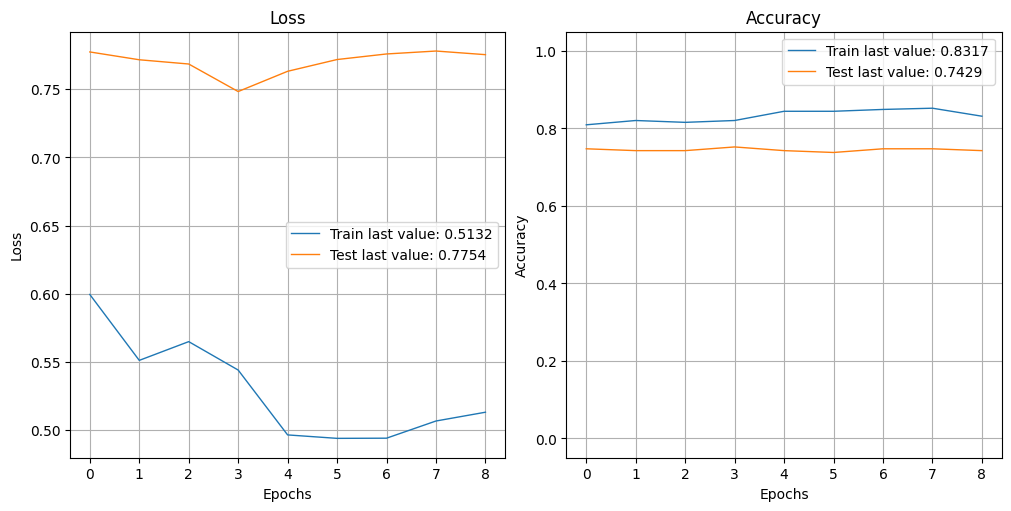

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history4)
plot_history(history4, path="standard.png")
plt.close()

# Synthèse

In [ ]:
history1 = pd.read_csv(path_data + 'training_history.csv')
tab_synth = history1[history1.val_accuracy == history1.val_accuracy.max()]

history2 = pd.read_csv(path_data + 'training_history2.csv')
tab_synth = pd.concat([tab_synth, history2[history2.val_accuracy == history2.val_accuracy.max()]], axis = 0)

history3 = pd.read_csv(path_data + 'training_history3.csv')
tab_synth = pd.concat([tab_synth, history3[history3.val_accuracy == history3.val_accuracy.max()]], axis = 0)

history4 = pd.read_csv(path_data + 'training_history4.csv')
tab_synth = pd.concat([tab_synth, history4[history4.val_accuracy == history4.val_accuracy.max()]], axis = 0)

tab_synth

epoch  accuracy      loss  val_accuracy  val_loss
12     12  0.958333  0.103150      0.821429  0.935819
13      9  0.911111  0.247449      0.866667  0.326271
9       9  0.930159  0.191711      0.804762  1.411967
9       9  0.780952  0.704520      0.780952  0.758000

Text(0.5, 1.0, 'Best accuracy values with different approach')

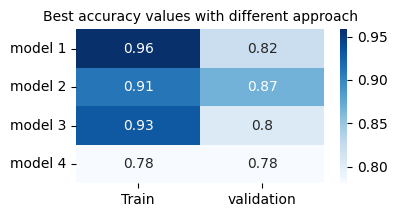

In [ ]:
df_eval = pd.DataFrame(np.array(tab_synth[['accuracy', 'val_accuracy']]),
                       index = ['model 1', 'model 2', 'model 3', 'model 4'],
                       columns = ['Train', 'validation'])
plt.figure(figsize = (4,2))
sns.heatmap(df_eval, annot=True, cmap="Blues")
plt.title('Best accuracy values with different approach', fontsize=10)